In [8]:
%%bash

# wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
# wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg

--2021-04-19 14:10:01--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg’

     0K .......... .......... .......... .........            100% 66.4M=0.001s

2021-04-19 14:10:02 (66.4 MB/s) - ‘dancing.jpg’ saved [40484/40484]



In [3]:
import sys
sys.path.append('..')

from rosettastone import maxact

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("picasso.jpg")
content_img = image_loader("dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

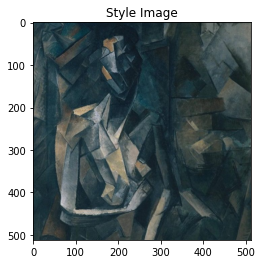

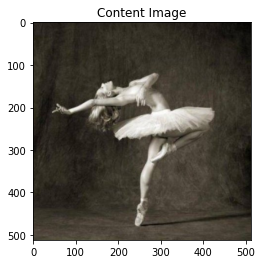

In [8]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [9]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [10]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [11]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [12]:
#cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [13]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [14]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

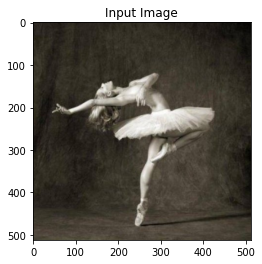

In [15]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [16]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [17]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


<ipython-input-13-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-13-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 4.544885 Content Loss: 4.108835

run [100]:
Style Loss : 1.161452 Content Loss: 3.070663

run [150]:
Style Loss : 0.716196 Content Loss: 2.665931

run [200]:
Style Loss : 0.474569 Content Loss: 2.500422

run [250]:
Style Loss : 0.344507 Content Loss: 2.413841

run [300]:
Style Loss : 0.262607 Content Loss: 2.358680



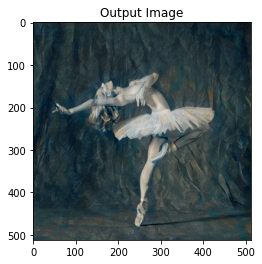

In [18]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [67]:
class IndifferenceLoss(nn.Module):

    def __init__(self, target):
        super().__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)

        x_orig = self.orig_in_module(x)
        x_orig = self.orig_post_module(x)

        x_alt = self.alt_in_module(x)
        x_alt = self.alt_pst_module(x)        return input

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [172]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

#import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dnet.requires_grad_(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

[1,  2000] loss: 2.158
[1,  4000] loss: 1.822
[1,  6000] loss: 1.643
[1,  8000] loss: 1.551
[1, 10000] loss: 1.510
[1, 12000] loss: 1.451
[2,  2000] loss: 1.371
[2,  4000] loss: 1.350
[2,  6000] loss: 1.304
[2,  8000] loss: 1.295
[2, 10000] loss: 1.287
[2, 12000] loss: 1.264
Finished Training
Accuracy of the network on the 10000 test images: 56 %


In [276]:
def freezer(module):
    for param in module.parameters():
        param.requires_grad = False

        
def weight_reset(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()
        

class DisentegelmentNet(nn.Module):

    def __init__(self, net, disentanglement_module_name, proceeding_module_name):
        super().__init__()
        self.net = copy.deepcopy(net)
        self.disentanglement_module_name = disentanglement_module_name
        self.proceeding_module_name = proceeding_module_name
        self._build()
        freezer(self.net)

    def _build(self):
        pre_module = nn.Sequential()
        orig_disentanglement_module = nn.Sequential()
        orig_post_module = nn.Sequential()
        alt_disentanglement_module = nn.Sequential()
        alt_post_module = nn.Sequential()

        modules_iter = self.net.named_children()

        for name, layer in modules_iter:
            if name == self.disentanglement_module_name:
                break
            pre_module.add_module(name, copy.deepcopy(layer))
            feezer(pre_module)


        orig_disentanglement_module.add_module(name, copy.deepcopy(layer))
        freezer(orig_disentanglement_module)

        alt_disentanglement_module.add_module(name, copy.deepcopy(layer))
        alt_disentanglement_module.apply(weight_reset)

        for name, layer in modules_iter:
            orig_post_module.add_module(name, copy.deepcopy(layer))
            alt_post_module.add_module(name, copy.deepcopy(layer))
            if name == self.proceeding_module_name:
                break

        freezer(orig_post_module)
        freezer(alt_post_module) # tricky, i need to catch the first going out weights, but it is good for now

        self.add_module('pre_module', pre_module)
        self.add_module('orig_disentanglement_module', orig_disentanglement_module)
        self.add_module('alt_disentanglement_module', alt_disentanglement_module)
        self.add_module('orig_post_module', orig_post_module)
        self.add_module('alt_post_module', alt_post_module)
        
        
        #self.add_module('indifference_loss', nn.MSELoss())

    def forward(self, x):
        x = self.pre_module(x)

        x_orig = self.orig_disentanglement_module(x)
        x_orig = self.orig_post_module(x_orig)

        x_alt = self.alt_disentanglement_module(x)
        x_alt = self.alt_post_module(x_alt)

        indifference_loss = (F.mse_loss(x_orig, x_alt, reduction='none')
                             .mean(dim=(1, 2, 3)))
        return indifference_loss #self.indifference_loss(x_orig, x_alt)

    def get_named_parameters(self):
        return [name
                for name, parameter in self.named_parameters()
                if parameter.requires_grad]

    

dnet = DisentegelmentNet(net.cpu(), 'conv2', 'pool2')
dnet.to(device)

dnet(images)

dnet.get_named_parameters()

F.mse_loss(dnet.orig_disentanglement_module.conv2.weight, dnet.alt_disentanglement_module.conv2.weight), F.mse_loss(dnet.orig_disentanglement_module.conv2.bias, dnet.alt_disentanglement_module.conv2.bias)
# INPUT torch.Size([4, 3, 32, 32])
# PRE torch.Size([4, 6, 14, 14])
# DISEN torch.Size([4, 16, 10, 10])
# POST torch.Size([4, 120])

(tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.1897, device='cuda:0', grad_fn=<MseLossBackward>))

In [277]:
optimizer = optim.SGD(dnet.parameters(), lr=0.01)

for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _ = data
        inputs = inputs.to(device)
#        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = torch.mean(dnet(inputs))
        #loss = dnet.indifference_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')



avgs = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, _ = data
        images = images.to(device)
        #labels = labels.to(device)

        outputs = dnet(images)
        bavg = torch.mean(outputs.data)
        total += outputs.size(0)
        avgs += bavg

print('Avg of the network on the 10000 test images: %d %%' % (
    100 * avgs / total))

[1,  2000] loss: 0.256
[1,  4000] loss: 0.055
[1,  6000] loss: 0.028
[1,  8000] loss: 0.018
[1, 10000] loss: 0.012
[1, 12000] loss: 0.009
[2,  2000] loss: 0.007
[2,  4000] loss: 0.005
[2,  6000] loss: 0.005
[2,  8000] loss: 0.004
[2, 10000] loss: 0.003
[2, 12000] loss: 0.003
[3,  2000] loss: 0.002
[3,  4000] loss: 0.002
[3,  6000] loss: 0.002
[3,  8000] loss: 0.002
[3, 10000] loss: 0.001
[3, 12000] loss: 0.001
Finished Training
Avg of the network on the 10000 test images: 0 %


In [278]:
F.mse_loss(dnet.orig_disentanglement_module.conv2.weight, dnet.alt_disentanglement_module.conv2.weight), F.mse_loss(dnet.orig_disentanglement_module.conv2.bias, dnet.alt_disentanglement_module.conv2.bias)

(tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward>))

In [279]:
net.conv2.bias

Parameter containing:
tensor([-0.3285, -0.0890, -0.2727, -0.0880,  0.0301, -0.1476, -0.7473,  0.0825,
         0.8797,  0.2738, -0.4600, -0.0070,  0.7093,  0.7742,  0.1185,  0.3181],
       requires_grad=True)

In [280]:
dnet.orig_disentanglement_module.conv2.bias

Parameter containing:
tensor([-0.3285, -0.0890, -0.2727, -0.0880,  0.0301, -0.1476, -0.7473,  0.0825,
         0.8797,  0.2738, -0.4600, -0.0070,  0.7093,  0.7742,  0.1185,  0.3181],
       device='cuda:0')

In [281]:
dnet.alt_disentanglement_module.conv2.bias

Parameter containing:
tensor([-0.3054, -0.0801, -0.2401, -0.0859,  0.0308, -0.1326, -0.6719,  0.0935,
         0.8244,  0.2627, -0.4466,  0.0131,  0.6655,  0.7209,  0.0940,  0.2969],
       device='cuda:0', requires_grad=True)

In [ ]:
"""
i = 0  # increment every time we see a conv
for layer in net.children():
    print(layer)
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    
    elif isinstance(layer, nn.F.mse_loss):
        name = 'i_{}'.format(i)
        # The in-place version doesn't play very nicely with the ContentLoss
        # and StyleLoss we insert below. So we replace with out-of-place
        # ones here.
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    elif isinstance(layer, nn.Linear):
        name = 'linear' # TODO
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    if name == 'conv_2':
        state = 'in'
    if name == 'linear':
        state = 'post'

        
    if state == 'pre':
        pre_module.add_module(name, layer)
    
        
    if is_alt_branch:
        alt_layer = copy.deepcopy(layer)
        alt_branch.add_module(f'alt_{name}',  alt_layer)

        
last_layer = list(model.children())[-1]
alt_branch.add_module('indifference_loss', IndifferenceLoss(last_layer))
print(alt_branch)

    
    
"""
"""
    if name in content_layers:
        # add content loss:
        target = model(content_img).detach()
        content_loss = ContentLoss(target)
        model.add_module("content_loss_{}".format(i), content_loss)
        content_losses.append(content_loss)

    if name in style_layers:
        # add style loss:
        target_feature = model(style_img).detach()
        style_loss = StyleLoss(target_feature)
        model.add_module("style_loss_{}".format(i), style_loss)
        style_losses.append(style_loss)

# now we trim off the layers after the last content and style losses
for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
        break

model = model[:(i + 1)]

return model, style_losses, content_losses
""";

In [58]:
from torchviz import make_dot

!pip install torchviz
#make_dot(net(x), params=dict(list(net.named_parameters()))).render("rnn_torchviz", format="png")


NameError: name 'x' is not defined

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


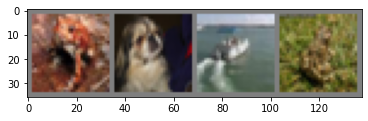

 frog   dog  ship  frog


In [107]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

[1,  2000] loss: 2.195
[1,  4000] loss: 1.901
[1,  6000] loss: 1.736
[1,  8000] loss: 1.602
[1, 10000] loss: 1.528
[1, 12000] loss: 1.439
[2,  2000] loss: 1.381
[2,  4000] loss: 1.354
[2,  6000] loss: 1.310
[2,  8000] loss: 1.285
[2, 10000] loss: 1.272
[2, 12000] loss: 1.237
Finished Training


In [26]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

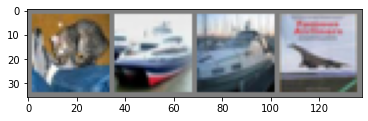

GroundTruth:    cat  ship  ship plane


In [27]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [28]:
# net = Net()
# net.load_state_dict(torch.load(PATH))

In [29]:
images = images.to(device)

outputs = net(images)

In [30]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog   car   car plane


Accuracy of the network on the 10000 test images: 55 %


In [32]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 79 %
Accuracy of  bird : 34 %
Accuracy of   cat : 38 %
Accuracy of  deer : 35 %
Accuracy of   dog : 37 %
Accuracy of  frog : 83 %
Accuracy of horse : 67 %
Accuracy of  ship : 64 %
Accuracy of truck : 59 %


In [21]:
list(net.named_modules())

[('',
  Net(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )),
 ('conv1', Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))),
 ('pool',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('conv2', Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))),
 ('fc1', Linear(in_features=400, out_features=120, bias=True)),
 ('fc2', Linear(in_features=120, out_features=84, bias=True)),
 ('fc3', Linear(in_features=84, out_features=10, bias=True))]

In [23]:
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           num_workers=2)

# acts = maxact.harvest_activations(net, trainloader, module_names={'conv2'})

In [82]:
# harvast activations
# fix network parameters
# reinitialize new parameters

# iterate over the data


import copy

net2 = copy.deepcopy(net)
net2 = net2.to(device)
net2.conv1.reset_parameters()



with torch.no_grad():
    q =  {name: param.clone() for name, param in net.named_parameters()
        if name.startswith('conv1')}

 
    qq =  {name: param for name, param in net2.named_parameters()
        if name.startswith('conv1')}

    qq['conv1.weight'][1:, :, :] = q['conv1.weight'][1:, :, :]
    qq['conv1.bias'][1:] = q['conv1.bias'][1:]

    

activations, handles = maxact.hook_activations(net, modules)


#for handle in handels.values():
#        handle.remove()

In [89]:
criterion_indifference = nn.MSELoss()
optimizer_indifference = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [88]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.no_grad():
            net(inputs)
            
        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

tensor([[[ 0.0463,  0.0451, -0.0311,  0.2435,  0.3322],
         [ 0.0407,  0.0334,  0.0069, -0.0084,  0.2472],
         [ 0.0956,  0.1986,  0.0749, -0.1971,  0.0481],
         [-0.0274,  0.2611,  0.0792, -0.1645,  0.0088],
         [ 0.0191,  0.1665,  0.2452,  0.0411, -0.1945]],

        [[-0.0864, -0.1903, -0.1975, -0.2065,  0.0258],
         [ 0.1262, -0.0953, -0.3267, -0.3978, -0.0714],
         [ 0.0604,  0.1160, -0.2142, -0.4526, -0.2006],
         [ 0.0352,  0.0337,  0.0762, -0.4008, -0.1905],
         [-0.0725,  0.1961,  0.0973, -0.2468, -0.1441]],

        [[ 0.0576,  0.0617, -0.1746, -0.1564, -0.0106],
         [ 0.2046,  0.2478, -0.1537, -0.2497, -0.0619],
         [ 0.2405,  0.3903, -0.1493, -0.3667, -0.1625],
         [ 0.2909,  0.4164,  0.0955, -0.3131, -0.2681],
         [ 0.1754,  0.2619,  0.2468,  0.0419, -0.1610]]], device='cuda:0',
       grad_fn=<SelectBackward>)